In [ ]:
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.callbacks import  EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from keras import  backend as K
import tensorflow_datasets as tfds

In [ ]:
def load_dataset():
	# load dataset
	(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
	# reshape dataset to have a single channel
	x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
	x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
	# one hot encode target values

	return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# normalize to range 0-1
  train_norm = train.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
	# return normalized images

  return train_norm, test_norm

In [ ]:
x_train, x_test = prep_pixels(x_train,x_test)

In [ ]:
print(x_test.shape)

(10000, 28, 28, 1)


In [ ]:
# Create light-weight model
model = models.Sequential()
model.add(layers.Flatten(input_shape = (28, 28)))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
model.fit(x_train,
          y_train,
          epochs = 100,
          validation_data=(x_test,y_test))

Epoch 1/100
1875/1875 [==============================] - 19s 3ms/step - loss: 0.4528 - accuracy: 0.8697 - val_loss: 0.1409 - val_accuracy: 0.9554
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1139 - accuracy: 0.9649 - val_loss: 0.1087 - val_accuracy: 0.9659
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0763 - accuracy: 0.9771 - val_loss: 0.0962 - val_accuracy: 0.9710
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0597 - accuracy: 0.9816 - val_loss: 0.0881 - val_accuracy: 0.9750
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0454 - accuracy: 0.9851 - val_loss: 0.0826 - val_accuracy: 0.9748
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0367 - accuracy: 0.9879 - val_loss: 0.0909 - val_accuracy: 0.9742
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0954 - val_a

In [ ]:
def plot_confusion_matrix(x_test, y_test, model):
  y_test = tf.keras.utils.to_categorical(y_test)
  predictions = model.predict_classes(x_test)
  y_test = np.argmax(y_test, axis =1)
  cm = confusion_matrix(y_test, predictions)
  class_labels = list([0,1,2,3,4,5,6,7,8,9])
  fig = plt.figure(figsize = (8,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='Blues',fmt='g');
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  ax1.set_xticklabels(class_labels)
  ax1.set_yticklabels(class_labels, rotation = "horizontal")
  plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


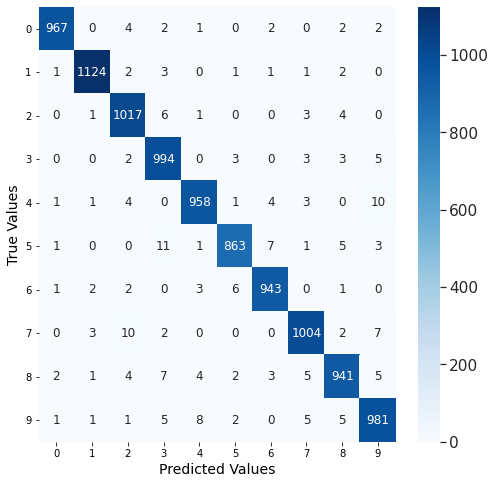

In [ ]:
plot_confusion_matrix(x_test, y_test, model)

In [ ]:
W1 = model.layers[1].weights
W2 = model.layers[2].weights
W3 = model.layers[3].weights

In [ ]:
# SVD compression
def svd(matrix, k):
  U, s, V = np.linalg.svd(matrix, full_matrices=False)
  Uk = U[:, :k]
  sk = s[:k]
  Vk = V[:k, :]
  U_prime = Uk*sk
  return U_prime, Vk

In [ ]:
#Compressing on each layers
def compressed(W1,W2,W3, k):
  U1, V1 = svd(W1[0], int(W1[0].shape[1]/k))
  U2, V2 = svd(W2[0], int(W2[0].shape[1]/k))
  U3, V3 = svd(W3[0], int(W3[0].shape[1]/k))
  return U1, V1, U2, V2, U3, V3

In [ ]:
# 2X Compression
U1, V1, U2, V2, U3, V3 = compressed(W1,W2,W3, 2)

In [ ]:
print(V1.shape)

(50, 100)


In [ ]:
# Define new model
def redefine_model():
  model = models.Sequential()
  model.add(layers.Flatten(input_shape = (28,28)))
  model.add(layers.Dense(U1.shape[1], use_bias= False))
  model.add(layers.Dense(V1.shape[1], activation = 'relu'))
  model.add(layers.Dense(U2.shape[1], use_bias= False))
  model.add(layers.Dense(V2.shape[1], activation = 'relu'))
  model.add(layers.Dense(U3.shape[1], use_bias= False))
  model.add(layers.Dense(V3.shape[1]))
  
  return model

In [ ]:
new_model = redefine_model()

In [ ]:
# Set the weights of the original model after training to the new model
def set_weight_model(model, U1, W1, V1, U2, W2, V2, U3, W3, V3, k):
  model.layers[1].set_weights([U1])
  model.layers[2].set_weights([V1,W1[1].numpy()])
  model.layers[3].set_weights([U2])
  model.layers[4].set_weights([V2,W2[1].numpy()])
  model.layers[5].set_weights([U3])
  model.layers[6].set_weights([V3,W3[1].numpy()])
  return model

In [ ]:
new_model = set_weight_model(new_model, U1, W1, V1, U2, W2, V2, U3, W3, V3,2)

In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                39200     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                2500      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 250       
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],)

In [ ]:
new_model.fit(x_train,
              y_train,
          epochs = 10,
          validation_data=(x_test,y_test),)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2778 - accuracy: 0.9494 - val_loss: 0.2043 - val_accuracy: 0.9637
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0659 - accuracy: 0.9825 - val_loss: 0.1644 - val_accuracy: 0.9730
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0469 - accuracy: 0.9865 - val_loss: 0.1952 - val_accuracy: 0.9640
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0498 - accuracy: 0.9854 - val_loss: 0.1463 - val_accuracy: 0.9746
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0377 - accuracy: 0.9896 - val_loss: 0.1452 - val_accuracy: 0.9726
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0351 - accuracy: 0.9898 - val_loss: 0.1512 - val_accuracy: 0.9713
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0349 - accuracy: 0.9889 - val_loss: 0.1312 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


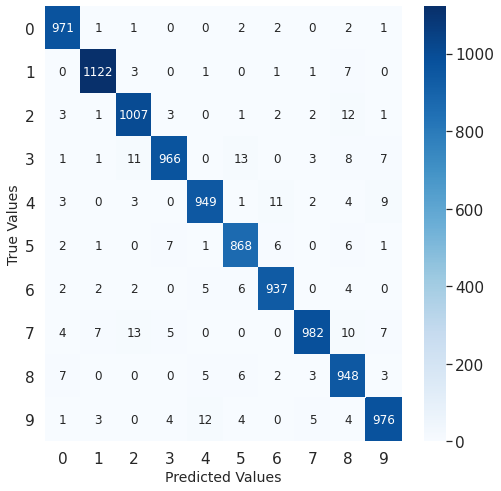

In [ ]:
plot_confusion_matrix(x_test, y_test, new_model)

In [ ]:
# 4X Compression
U1, V1, U2, V2, U3, V3 = compressed(W1,W2,W3, 4)

In [ ]:
new_model2 = redefine_model()
new_model2 = set_weight_model(new_model2, U1, W1, V1, U2, W2, V2, U3, W3, V3, 4)
new_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                19600     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               2600      
_________________________________________________________________
dense_11 (Dense)             (None, 12)                1200      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                650       
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 100       
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

In [ ]:
new_model2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])
new_model2.fit(x_train,
               y_train,
          epochs = 10,
          validation_data=(x_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.3722 - accuracy: 0.7526 - val_loss: 0.3158 - val_accuracy: 0.9396
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2246 - accuracy: 0.9475 - val_loss: 0.2806 - val_accuracy: 0.9438
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1721 - accuracy: 0.9594 - val_loss: 0.2761 - val_accuracy: 0.9514
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1430 - accuracy: 0.9661 - val_loss: 0.2389 - val_accuracy: 0.9605
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1206 - accuracy: 0.9698 - val_loss: 0.2357 - val_accuracy: 0.9607
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1126 - accuracy: 0.9720 - val_loss: 0.2443 - val_accuracy: 0.9607
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1027 - accuracy: 0.9729 - val_loss: 0.2387 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


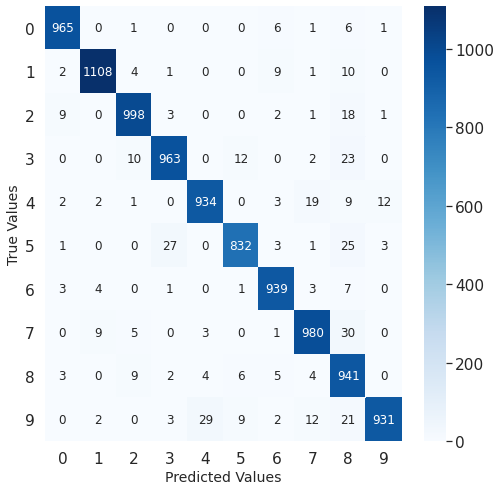

In [ ]:
plot_confusion_matrix(x_test, y_test, new_model2)

In [ ]:
# 8X Compression
U1, V1, U2, V2, U3, V3 = compressed(W1,W2,W3, 8)
new_model3 = redefine_model()
new_model3 = set_weight_model(new_model3, U1, W1, V1, U2, W2, V2, U3, W3, V3, 8)
new_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                9408      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 600       
_________________________________________________________________
dense_18 (Dense)             (None, 50)                350       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 50        
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

In [ ]:
new_model3.compile(optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])
new_model3.fit(x_train,
               y_train,
          epochs = 10,
          validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 2.8032 - accuracy: 0.2736 - val_loss: 1.2960 - val_accuracy: 0.5321
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2019 - accuracy: 0.5773 - val_loss: 1.1417 - val_accuracy: 0.7023
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0319 - accuracy: 0.7152 - val_loss: 1.0605 - val_accuracy: 0.7252
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9063 - accuracy: 0.7851 - val_loss: 1.0372 - val_accuracy: 0.8121
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8300 - accuracy: 0.8192 - val_loss: 0.9582 - val_accuracy: 0.7850
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7979 - accuracy: 0.8259 - val_loss: 0.8817 - val_accuracy: 0.8323
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7578 - accuracy: 0.8394 - val_loss: 0.8750 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


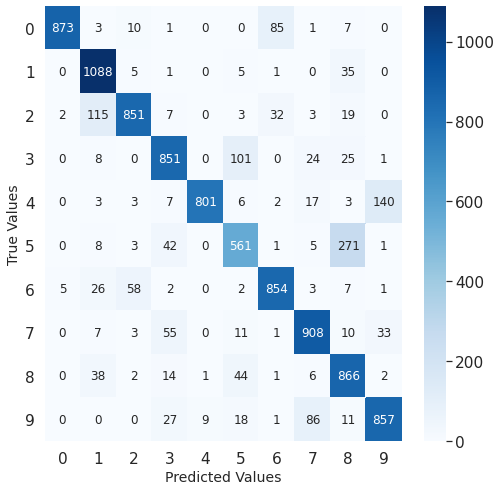

In [ ]:
plot_confusion_matrix(x_test, y_test, new_model3)